# Introduction of camera

![title](images/intro0.png)

![title](images/Intrinsic.png)

![title](images/Extrinsic1.png)

![title](images/distortion.png)

# How to convert 2d information to 3d?

![title](images/triangulation.png)

# 1. Orgaize file and generate synchronized video

## 1.1 Manually organize the collected video files (prototype version) (specific format as shown below, files must be placed exactly as indicated).

In [ ]:
import os
def int_to_char(n):
    if 0 <= n <= 25:
        return chr(ord('A') + n)
    else:
        raise ValueError("Input must be between 0 and 25")



In [ ]:
pwd

In [ ]:
root_path = 'Data/4cams'
project_names = ['xyz','xyz_static','intrinsic4cam','mice','checker7mm'] #,''
number_camera = 4

cam_names = []
for i in range(number_camera):
    cam_names.append('cam'+int_to_char(i))
for p in project_names:
    for c in cam_names:
        each_path = os.path.join(root_path,os.path.join(p,c))
        if not os.path.exists(each_path):
            os.makedirs(each_path)

## 1.2 Synchronize the video files and manually place them in the designated locations (prototype version).

In [ ]:

from utils.Sync_prototype import synchronize_videos 

In [ ]:

synchronize_videos(root_path, project_names,cam_names)

# WorkFlow

![title](images/general_workflow.png)

# 2. create the XYZ object and training a DeepLabCut to detect it


<div>
<img src="images/target.png" width="500"/>
</div>

In [ ]:
from utils.Extrinsic_check import XYZ_object
xyz = XYZ_object(scaling = 1) #set it to 1 if it is about 6cm object

## 3. Train a DeepLabCut model using transfer learning to detect known 3D objects, and manually place them in the corresponding Anipose positions.


![title](images/synthetic_model.png)

In [ ]:
import deeplabcut
import os
import pandas as pd
import numpy as np
import tqdm
from utils.Extrinsic_check import Generate_refined_training_data

In [ ]:
pretrained_config_path = os.path.join(os.getcwd(),'DeepLabCut/pretrained_xyz_model/config.yaml')
pretrained_model_appendix = 'DLC_dlcrnetms5_XYZ_resnet50Aug1shuffle1_900000'

In [ ]:
object_video_path_list = []
for project_name in ['xyz','xyz_static',]:
    object_video_folder = os.path.join(os.getcwd(), os.path.join('Data',f'4cams/{project_name}'))
    
    object_video_name_list = [f'{project_name}-camA', 
                              f'{project_name}-camB', 
                              f'{project_name}-camC', 
                              f'{project_name}-camD',]
    video_appendix         = '.mp4'
    
    
    for video_name in tqdm.tqdm(object_video_name_list):
        video_path = os.path.join(object_video_folder, video_name + video_appendix)
        object_video_path_list.append(video_path)

In [ ]:
deeplabcut.analyze_videos(pretrained_config_path, 
                          object_video_path_list, 
                          save_as_csv=False)

In [ ]:
# load the intrinsic parameters if you have one
# Load intrinsic calibration result
try:
    intrinsic_result = np.load(os.path.join(os.path.join(os.getcwd(),'Data/4cams/intrinsic4cam',),
                                            'intrinsic_params.npy'),allow_pickle=True).item()
except:
    intrinsic_result = None

In [ ]:

dlc_iter1_project_path = os.path.join(os.getcwd(),'DeepLabCut/XYZ-fintune_iter1')
dlc_iter2_project_path = os.path.join(os.getcwd(),'DeepLabCut/XYZ-fintune_iter2')
dlc_iter3_project_path = os.path.join(os.getcwd(),'DeepLabCut/XYZ-fintune_iter3')


In [ ]:
object_video_path_list

In [ ]:

for video_path in tqdm.tqdm(object_video_path_list):
    prediction_path = os.path.join(video_path[:-4]+pretrained_model_appendix+'.h5' )
    if intrinsic_result is not None:
        cam_count   = video_name.split('-')[-1]
        instrinsicM = intrinsic_result[cam_count]['intr']
        dist        = intrinsic_result[cam_count]['dist']
    else:
        instrinsicM = None
        dist        = None
    Generate_refined_training_data(prediction_path, video_path, 
                                   dlc_iter1_project_path,
                                   xyz = xyz, obj_scale = 1, obj_unit = 'mm', 
                                   instrinsicM = instrinsicM, dist     = dist,
                                   min_num_kp_fitting = 6,
                                   error_threshold    = 5,
                                   skip_frames = 10,
                                   conf_thres = .4)



In [ ]:
deeplabcut.add_new_videos(os.path.join(dlc_iter1_project_path,'config.yaml'),
                          object_video_path_list, copy_videos=True)

### Now, it is time to go to deeplabcut GUI for easier life

![title](images/dlc0.png)

![title](images/dlc1.png)

### For more iterations, repeat previous steps.

In [ ]:

for video_name in tqdm.tqdm(object_video_name_list):
    video_path = os.path.join(object_video_folder_iter1, video_name + video_appendix)
    prediction_path = os.path.join(object_video_folder , video_name+pretrained_model_appendix+'.h5' )
    if intrinsic_result is not None:
        cam_count   = video_name.split('-')[-1]
        instrinsicM = intrinsic_result[cam_count]['intr']
        dist        = intrinsic_result[cam_count]['dist']
    else:
        instrinsicM = None
        dist        = None
    Generate_refined_training_data(prediction_path, video_path, 
                                   dlc_iter2_project_path,
                                   xyz = xyz, obj_scale = 1, obj_unit = 'mm', 
                                   instrinsicM = instrinsicM, dist     = dist,
                                   min_num_kp_fitting = 6,
                                   error_threshold    = 5,
                                   skip_frames = 10,
                                   conf_thres = .3)

In [ ]:
deeplabcut.add_new_videos(os.path.join(dlc_iter2_project_path,'config.yaml'),
                          object_video_path_list, copy_videos=True)

## 4. Use Anipose for camera calibration.

![title](images/checkerdescription.png)

In [ ]:
'''
In your terminal,
conda activate anipose
'''

In [ ]:
anipose calibrate

## 5. Use Anipose for 3D keypoint estimation.

In [ ]:
anipose triangulate

## 6. Check the results of Anipose. If the conditions are met, proceed (good to go). The conditions depend on the actual experiment. If not, go to step 7.


In [ ]:
from utils.Extrinsic_check import XYZ_object, compute_centroid,kabsch_algorithm,\
calculate_3d_error, threshold_confidence,initialize_intr,crop_keypoints
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import cv2
from utils.Intrinsic_check import iter_video

In [ ]:
# read anipose prediction

anipose_base_path = os.path.join(os.getcwd()[:-5],'anipose_experiment/')
for anipose_p in ['anipose_cylinder_bad_init']: #
    for file_p in ['gray.csv','gray_cylinder.csv','gray_static.csv']:
        anipose_prediction_path = anipose_base_path+ anipose_p  +'/videos/pose-3d/' + file_p
        print(anipose_prediction_path)
        try:
            prediction = pd.read_csv(anipose_prediction_path)
            N_frames = len(prediction)
            prediction3d = np.zeros((N_frames,xyz().shape[0],xyz().shape[1]))
            for i,j in enumerate(xyz.bodyparts):
                prediction3d[:,i,0] =  prediction[f'{j}_x'].values
                prediction3d[:,i,1] =  prediction[f'{j}_y'].values
                prediction3d[:,i,2] =  prediction[f'{j}_z'].values
            error_all = []
            for i in range(N_frames):
                error_each = calculate_3d_error(xyz(), prediction3d[i])
                #print(f"Mean error: {mean_error}")
                error_all.append(error_each )
            error_all = np.array(error_all)
            print('Project:',anipose_p, 'Trail:',file_p)
            print('median error:',np.round(np.median(error_all),4),'mm')
            print('mean error  :'  ,np.round(np.mean(error_all),4)  ,'mm')
            print('max error   :'   ,np.round(np.max(error_all) ,4)  ,'mm')
            print('min error   :'   ,np.round(np.min(error_all) ,4)  ,'mm')
            print('------------------------------------------')
        except:
            pass

## 7. Perform intrinsic calibration and check the error.


![title](images/checkerdescription.png)

In [ ]:
from utils.Intrinsic_check import CheckerBoard
# Define Checkerboard
checkerboard = CheckerBoard(12,9,7) # defined as calib.io

In [ ]:
from utils.Intrinsic_check import create_dataset_for_calibration
p  = 'intrinsic4cam'
for i in range(number_camera):
    YOUR_VIDEO_PATH    = os.path.join(root_path,p)
    YOUR_VIDEO_NAME    =  f'{p}-{cam_names[i]}.mp4'
    create_dataset_for_calibration(YOUR_VIDEO_PATH, YOUR_VIDEO_NAME ,checkerboard, 
                                   sample_ratio = .5)

In [ ]:
from utils.Intrinsic_check import kmean_pick_dataset
for i in range(number_camera):
    YOUR_VIDEO_PATH    = os.path.join(root_path,p)
    YOUR_VIDEO_NAME    =  f'{p}-{cam_names[i]}.mp4'
    checker_img_folder = os.path.join(YOUR_VIDEO_PATH,f'{YOUR_VIDEO_NAME[:-4]}_checker_img')
    # we choose a total of 128 images from the folder
    kmean_pick_dataset(checker_img_folder,numframes2pick = 128) 

### Delete the outliers in the folder YOUR_VIDEO_PATH/YOUR_VIDEO_NAME_checker_img/overlay

![title](images/badchecker2.png)

![title](images/badchecker3.png)

In [ ]:
### it split the checker images into two parts, training and validation.
from utils.Intrinsic_check import split_train_test
for i in range(number_camera):
    YOUR_VIDEO_PATH    = os.path.join(root_path,p)
    YOUR_VIDEO_NAME    =  f'{p}-{cam_names[i]}.mp4'
    checker_img_folder = os.path.join(YOUR_VIDEO_PATH,f'{YOUR_VIDEO_NAME[:-4]}_checker_img')
    split_train_test(checker_img_folder, train_test_ratio = 0.8)

In [ ]:
from utils.Intrinsic_check import calibrate_kmean_pick_frames
from utils.Intrinsic_check import validate_calibrate
# load imgpoints generate during creating datasets


result = {}
for i in range(number_camera):
    YOUR_VIDEO_PATH    = os.path.join(root_path,p)
    YOUR_VIDEO_NAME    =  f'{p}-{cam_names[i]}.mp4'
    checker_img_folder = os.path.join(YOUR_VIDEO_PATH,f'{YOUR_VIDEO_NAME[:-4]}_checker_img')
    ret,instrinsicM,dist = calibrate_kmean_pick_frames(checker_img_folder,checkerboard,numframes2pick = 64) 
    result[cam_names[i]] = {}
    result[cam_names[i]]['error'] = ret
    result[cam_names[i]]['intr']  = instrinsicM
    result[cam_names[i]]['dist']  = dist
    
    print('training reprojection error',ret,'pixels','\n',
          'intrinsic matrix:','\n',instrinsicM,'\n',
          'distortion','\n',np.round(dist,5))
    vali_error = validate_calibrate(checker_img_folder,checkerboard,instrinsicM,dist)
    print('validation error:', vali_error,'pixels')
    result[cam_names[i]]['val_error'] = vali_error
    print('-------------')
np.save(os.path.join(os.path.join(root_path,p),'intrinsic_params'),result)

###                   distorted image

![title](images/distortion_camB.png)

In [26]:
import numpy as np
import cv2
intrinsic_result = np.load(os.path.join(os.path.join(os.getcwd(),'Data/4cams/intrinsic4cam',),
                                            'intrinsic_params.npy'),allow_pickle=True).item()

intr_camB = intrinsic_result['camB']['intr'] 
idst_camB = intrinsic_result['camB']['dist']


In [30]:
%matplotlib inline

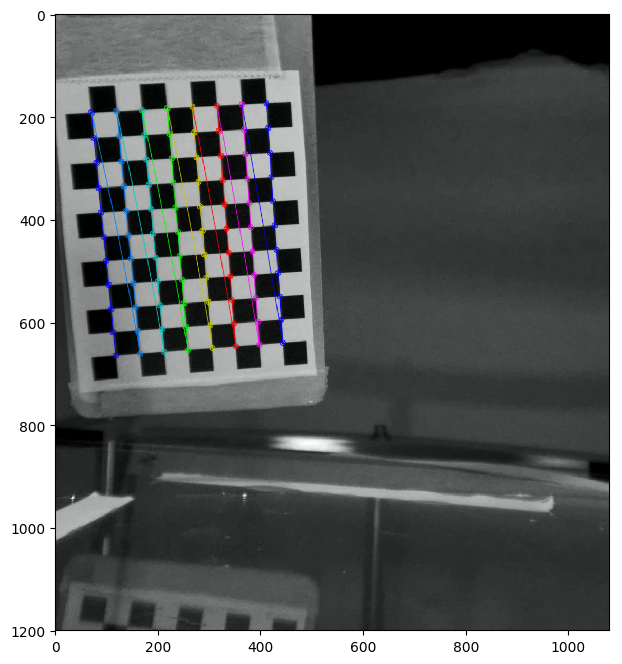

In [33]:
image = cv2.imread('images/distortion_camB.png')
undistorted_image = cv2.undistort(image, intr_camB, idst_camB)
plt.figure(figsize=(12,8),)
plt.imshow(undistorted_image)

## 8. Refine the object detection results and retain the accurate detection points.



In [34]:
from utils.Extrinsic_check import refine_dlc_prediction
from utils.Extrinsic_check import Generate_refined_training_data

In [35]:
#prediction_path = '/mnt/TeamShare/TM_Lab/HHao/CSHL/Demos/anipose_experiment/anipose_cylinder_refined/videos/pose-2d/gray_cylinder-camF.h5'
#video_path      =  '/mnt/TeamShare/TM_Lab/HHao/CSHL/Demos/anipose_experiment/anipose_cylinder_refined/videos/gray_cylinder-camF.mp4'

In [38]:
video_paths      =  ['DeepLabCut/XYZ-fintune_iter2/videos/xyz_static-camD.mp4',
                     'DeepLabCut/XYZ-fintune_iter2/videos/xyz_static-camC.mp4',
                     'DeepLabCut/XYZ-fintune_iter2/videos/xyz_static-camB.mp4',
                     'DeepLabCut/XYZ-fintune_iter2/videos/xyz_static-camA.mp4',
                     'DeepLabCut/XYZ-fintune_iter2/videos/xyz-camD.mp4',
                     'DeepLabCut/XYZ-fintune_iter2/videos/xyz-camC.mp4',
                     'DeepLabCut/XYZ-fintune_iter2/videos/xyz-camB.mp4',
                     'DeepLabCut/XYZ-fintune_iter2/videos/xyz-camA.mp4',]
DLC_appdix = 'DLC_resnet50_XYZ_resnet50Aug1shuffle1_1180000'
for video_path in video_paths:
    if intrinsic_result is not None:
        cam_count   = video_path.split('-')[-1][:-4]
        instrinsicM = intrinsic_result[cam_count]['intr']
        dist        = intrinsic_result[cam_count]['dist']
    else:
        instrinsicM = None
        dist  = None
    prediction_path = video_path[:-4] + DLC_appdix  + '.h5'
    refine_dlc_prediction(video_path,                # Path to the video file
                          prediction_path,           # Path to the prediction file
                          confident_threshold=0.8,   # Threshold for keypoint confidence (default: 0.6) 
                          xyz_scaling=1,             # Scaling factor for XYZ coordinates (default: 1,refers to original 6cm object)
                          instrinsicM=instrinsicM,          # Intrinsic camera matrix (not used here)
                          dist       =dist ,          # Distortion coefficients (not used here)
                          error_threshold=3,         # Threshold for allowable error (default: 3) 
                          min_number_kp_opt = 6,     #  Minimum number of keypoints for optimization (default: 6) 
                          output_appendix   = 'filtered',)

In [9]:
pwd

'/mnt/TeamShare/TM_Lab/HHao/CSHL/Demos'

## 9. Re-estimate the extrinsic parameters.

In [14]:
from utils.refine_calibration import refine_calibration

In [15]:
import os
from utils.Extrinsic_check import create_ba_dataset

In [18]:

anipose_path = 'anipose_demo/anipose_cylinder_bad_init'
intrinsic_result_path = os.path.join('Data/bk/intrinsic',
                                        'intrinsic_params.npy')  
video_folder  = 'Data/good_xyz_detection'
video_name_list = ['gray_static-camF', 'gray_static-camE','gray_static-camD', 
                   'gray_static-camC', 'gray_static-camB', 'gray_static-camA',]
video_name_list.sort()
all_points, all_scores = create_ba_dataset(video_folder,video_name_list)
refine_calibration(anipose_path,intrinsic_result_path, all_points, all_scores, file_appendix = '-refine')

[{'name': 'A', 'size': [1200, 1080], 'matrix': [[1761.6129622196183, 0.0, 548.3430158145428], [0.0, 1757.954775971478, 518.0953620569277], [0.0, 0.0, 1.0]], 'distortions': [-0.5317906043563375, 0.44400010489867425, -0.0003132935240451112, 0.0019011799310898131, 2.610022220281375], 'rotation': [0.12056152021536418, -0.004377966524627778, 0.2577695076065057], 'translation': [-3.3875489225578215, 18.350496779067925, 110.4370826080532]}, {'name': 'B', 'size': [1080, 1200], 'matrix': [[1780.496333645694, 0.0, 531.5778877847557], [0.0, 1780.9089856759083, 575.2657025770742], [0.0, 0.0, 1.0]], 'distortions': [-0.48417096218600003, -0.438085542742133, -0.0017846622543420542, -0.0027830187339227177, 4.507491656093445], 'rotation': [1.5985377408779242, -0.22153260346409875, 0.4056016548823798], 'translation': [-8.82402628371924, 57.862021049858974, 146.96546151438093]}, {'name': 'C', 'size': [1080, 1200], 'matrix': [[1792.8965273230551, 0.0, 537.5852950223667], [0.0, 1787.3258321315866, 643.3274

KeyboardInterrupt: 

## 11 .Return to step 6 to check the results of Anipose.

In [39]:
# read anipose prediction
import os
import pandas as pd
import numpy as np
anipose_base_path = os.path.join(os.getcwd()[:-5],'anipose_experiment/')
for anipose_p in ['anipose_cylinder_bad_init_finetune']: #
    for file_p in ['gray.csv','gray_cylinder.csv','gray_static.csv']:
        anipose_prediction_path = anipose_base_path+ anipose_p  +'/videos/pose-3d/' + file_p
        print(anipose_prediction_path)
        
        prediction = pd.read_csv(anipose_prediction_path)
        N_frames = len(prediction)
        prediction3d = np.zeros((N_frames,xyz().shape[0],xyz().shape[1]))
        for i,j in enumerate(xyz.bodyparts):
            prediction3d[:,i,0] =  prediction[f'{j}_x'].values
            prediction3d[:,i,1] =  prediction[f'{j}_y'].values
            prediction3d[:,i,2] =  prediction[f'{j}_z'].values
        error_all = []
        for i in range(N_frames):
            error_each = calculate_3d_error(xyz(), prediction3d[i])
            #print(f"Mean error: {mean_error}")
            error_all.append(error_each )
        error_all = np.array(error_all)
        print('Project:',anipose_p, 'Trail:',file_p)
        print('median error:',np.round(np.median(error_all),4),'mm')
        print('mean error  :'  ,np.round(np.mean(error_all),4)  ,'mm')
        print('max error   :'   ,np.round(np.max(error_all) ,4)  ,'mm')
        print('min error   :'   ,np.round(np.min(error_all) ,4)  ,'mm')
        print('------------------------------------------')

/mnt/TeamShare/TM_Lab/HHao/CSHL/anipose_experiment/anipose_cylinder_bad_init_finetune/videos/pose-3d/gray.csv


NameError: name 'xyz' is not defined

# 12. Analysis on 3d keypoint

In [1]:
# load csv file
import pandas as pd

In [2]:
data3d = pd.read_csv('anipose_demo/mice_2023/videos/pose-3d/DTL2_2023-07-28_1.csv')

In [3]:
import umap

In [4]:
reducer = umap.UMAP()

In [5]:
embedding = reducer.fit_transform(data3d)


/home/murphylab/anaconda3/envs/pokemouse/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [6]:
import matplotlib.pyplot as plt

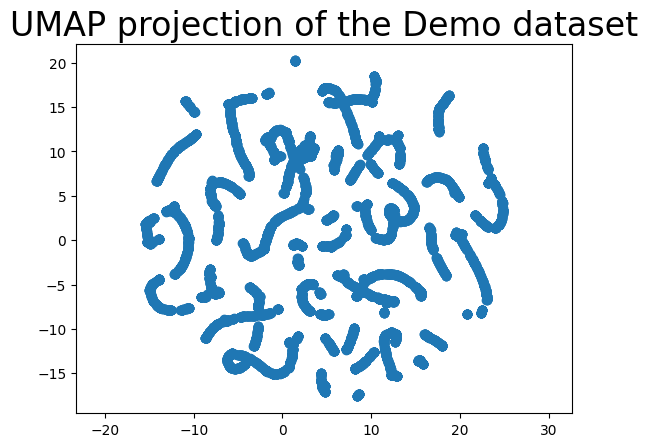

In [7]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Demo dataset', fontsize=24);

![title](images/umap.png)

In [8]:

from sklearn.cluster import HDBSCAN


hdb_all = HDBSCAN(cluster_selection_epsilon = 1) # max_cluster_size= 10) #min_cluster_size=None,

hdb_all.fit(embedding)

HDBSCAN(cluster_selection_epsilon=1)

In [14]:
import numpy as np
def plot(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    # The probability of a point belonging to its labeled cluster determines
    # the size of its marker
    proba_map = {idx: probabilities[idx] for idx in range(len(labels))}
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_index = np.where(labels == k)[0]
        for ci in class_index:
            ax.plot(
                X[ci, 0],
                X[ci, 1],
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=4 if k == -1 else 1 + 5 * proba_map[ci],
            )
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"{preamble} number of clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"
    ax.set_title(title)
    plt.tight_layout()

(-30.0, 30.0)

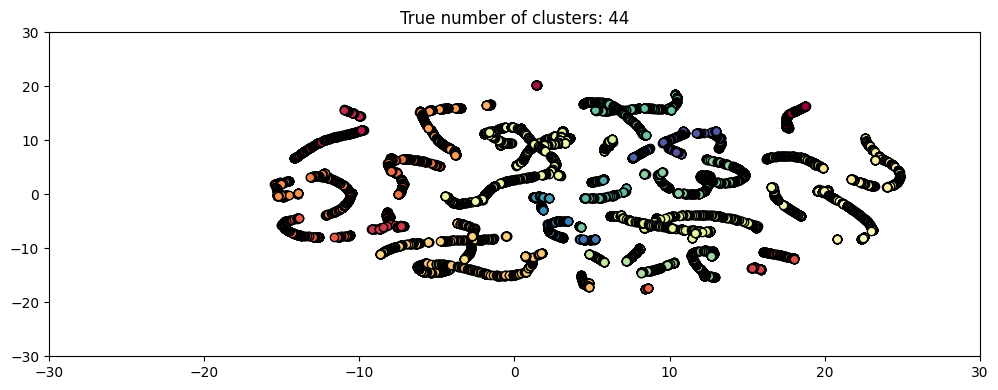

In [17]:
plot(embedding, labels=hdb_all.labels_, ground_truth=True)
plt.xlim(-30, 30) 
plt.ylim(-30, 30) 

![title](images/clustering.png)